# Goal:
* Split the data into *training*- and *validation*- subsets.
* Examine types of data in the columns.
* Look for missing values and consider strategies to handle missing values in each column.
* Construct new, purely numerical features that are feasable to fit a classifier to.
* Save the whole developed preprecessing pipeline as a Python script to be used in later notebooks without a hassle.
* Visualize the effects of preprocessing by plotting the selected features on a scatter plot after dimensionality reduction down to 2D.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pprint import pprint
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, PCA

---
Define simple utility-class (it serves to reshape a 1D *row* into a 2D *column*).

In [2]:
def row_to_column(row):
    if type(row) == type(pd.Series()):
        return pd.DataFrame(row)
    elif type(row) == type(np.empty(0)):
        return row.reshape(-1,1)
    else:
        raise ValueError("row_to_column expected pandas Series or 1D numpy array")
        
class Row_Flipper(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        if len(X.shape) != 1:
            raise ValueError('RowFlipper expected 1D object, but got argument of shape {X.shape}')
        return row_to_column(X)

---
## Load in the training data.
The test-dataset is in the same directory and is not loaded in this notebook.

In [3]:
data_trainval = pd.read_csv(os.path.join('data', 'train.csv'))

---
Copy the column description from
https://www.kaggle.com/c/titanic/data

Note the meaning of *SibSp* and *Parch*.


Variable | Definition | Key
--- | --- | ---
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex |  	
Age | Age in years |
sibsp |	# of siblings / spouses aboard the Titanic 	
parch | # of parents / children aboard the Titanic 	
ticket | Ticket number 	
fare | Passenger fare 	
cabin | Cabin number 	
embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton

---
Have a quick look at the number of records, types of variables and the fraction and placement of missing values.

In [4]:
data_trainval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


There are no missing values in the majority of columns.

---
## Train - val split
Split the traininig dataset into features that will be used for classification (X_train) and the labels (y_train). Split the training set further into proper *train* and *validation* in 4:1 proportion, using stratification based on frequencies of the binary y labels.

In [5]:
X_trainval = data_trainval[data_trainval.columns.drop('Survived')]
y_trainval = data_trainval.Survived

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.3, stratify = y_trainval, random_state=42)

In [6]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((623, 11), (268, 11), (623,), (268,))

In [7]:
print(y_train.value_counts(normalize=True))
y_val.value_counts(normalize=True)

0    0.616372
1    0.383628
Name: Survived, dtype: float64


0    0.615672
1    0.384328
Name: Survived, dtype: float64

---
## Count the missing values.
There are many in two columns: *Age* and *Cabin*, few in the *Embarked*, and none in other columns. Let's leave them for now.

In [8]:
X_train.isnull().sum() / len(X_train)

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.191011
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.781701
Embarked       0.003210
dtype: float64

In [9]:
X_train.Embarked.isnull().sum()

2

---
## Examine *PassengerId*
PassengerId values are unique and equal to the (index + 1). Hence, we will ignore PassengerId in the analysis. The *y_train* already shares common index with *X_train*.

In [10]:
(np.array(X_train.PassengerId) == np.array(X_train.index) + 1).all()

True

In [11]:
X_train = X_train.drop('PassengerId', axis=1)

---
## Provisionally split the features into numerical and categorical
Start by splitting solely based on the datatype.

In [12]:
X_train.dtypes.value_counts()

object     5
int64      3
float64    2
dtype: int64

In [13]:
numerical_columns = [column for column in X_train if X_train[column].dtype in ['float64', 'int64']]
categorical_columns = [column for column in X_train if X_train[column].dtype in ['object']]

In [14]:
numerical_columns

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [15]:
categorical_columns

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

We already know that *Pclass* is a dicrete variable that takes values from a three-element sequence: (3, 2, 1). It is not obvious, whether it's better to treat those values as independent categories or rather as points in a one-dimensional continous space. But the former approach seems more sensible given that there are only three values which probably corresponded to qualitatively different situations of the passangers.

In [16]:
numerical_columns.remove('Pclass')

In [17]:
categorical_columns.append('Pclass')

---
---
## Examine the numerical features

In [18]:
X_train[numerical_columns].describe()

,Age,SibSp,Parch,Fare
count,504.000000,623.000000,623.000000,623.000000
mean,30.045476,0.457464,0.377207,30.874003
std,14.502377,0.964501,0.841409,47.760418
min,0.420000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.895800
50%,29.000000,0.000000,0.000000,13.500000
75%,39.000000,1.000000,0.000000,30.000000
max,80.000000,8.000000,6.000000,512.329200


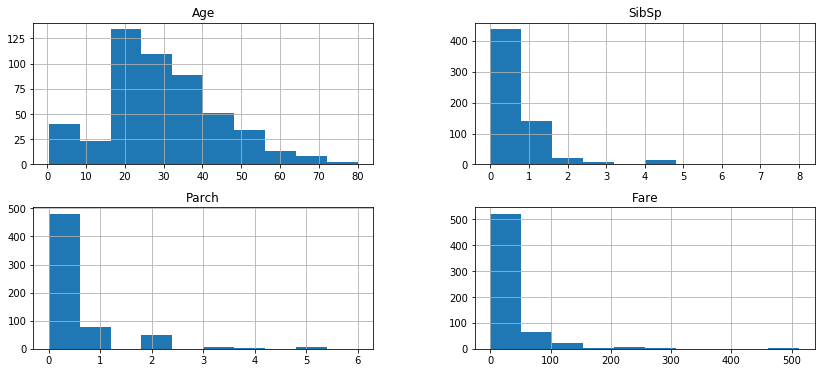

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14,6))
axes = axes.flatten()
# axes[-1].remove()

for index, column in enumerate(numerical_columns):
    X_train.hist(column=column, ax=axes[index])

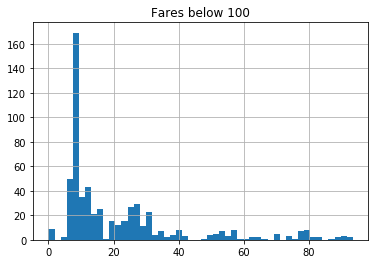

In [20]:
pd.DataFrame({'Fares below 100': X_train.Fare[X_train.Fare<100]}).hist(bins=50)
plt.show()

Recalling that there is a significant fraction of records with missing 'Age', and given the context of our analysis, is seems reasonable to split age into unordered categories. This way we can treat 'missing' as just another category next to 'children', 'adults' etc.

There already is a class in sklearn that serves to dicretize numerical variables (*KBinsDicretizer*) but it does not handle missing values and doesn't seem to allow for handpicked bins. Hence, it will be easier to define our own *Discretizer*. Notice that it is a stateless transformer (the *fit* methoed doen't do anything).

In [21]:
class Discretizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, name, tresholds, handle_missing=True):
        
        self.name = name
        self.tresholds = tresholds
        self.handle_missing = handle_missing
        
        self.columns = []
        self.inf_tresholds = [-np.inf] + tresholds + [np.inf]
        
        for index in range(len(self.inf_tresholds) - 1):
            self.columns.append(f"{self.name}_({self.inf_tresholds[index]},{self.inf_tresholds[index+1]}]")
        if self.handle_missing:
            self.columns.append(f"{self.name}_missing")
        
        return None
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        
        one_hots = np.zeros( (len(self.inf_tresholds) - 1 + int(self.handle_missing), len(X)) )
        for index in range(len(self.inf_tresholds) - 1):
            one_hots[index] = (X > self.inf_tresholds[index]) & (X <= self.inf_tresholds[index + 1])
            
        if self.handle_missing:
            one_hots[len(self.inf_tresholds) - 1] = X.isnull()
        elif X.isnull().any():
            raise ValueError("There's NAN's in the input")

        result = pd.DataFrame(one_hots.T, columns=self.columns, index = X.index)
            
        return result

Now we can do for example the following. (Note that we retain the freedom of tuning the tresholds later.)

In [22]:
age_discretizer = Discretizer('age', tresholds = [5, 10, 20, 30, 40, 50])
X_train.Age[2:5]

28      NaN
633     NaN
403    28.0
Name: Age, dtype: float64

In [23]:
age_discretizer.transform(X_train.Age[2:5])

,"age_(-inf,5]","age_(5,10]","age_(10,20]","age_(20,30]","age_(30,40]","age_(40,50]","age_(50,inf]",age_missing
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
403,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


We can use the same class to bin and one-hot-encode the *SibSp* and *Parch* variables. We will assume that there are no missing values in those features, and so we just want an error raised otherwise.

In [24]:
sibsp_discretizer = Discretizer('sibsp', tresholds = [0,1], handle_missing=False)
parch_discretizer = Discretizer('parch', tresholds = [0], handle_missing=False)

In [25]:
sibsp_discretizer.transform(X_train.SibSp).mean()

sibsp_(-inf,0]    0.701445
sibsp_(0,1]       0.226324
sibsp_(1,inf]     0.072231
dtype: float64

In [26]:
parch_discretizer.transform(X_train.Parch).mean()

parch_(-inf,0]    0.772071
parch_(0,inf]     0.227929
dtype: float64

Finally, the last numerical feature left: the Fare. Conceptually it as a continous, nonegative quantity (interestingly there are some zero values). We can see that its distribution is rather far from a normal one. One could apply the Yeo-Johnson transformation to it (see *PowerTransformer*) to make it more gaussian. But, for the sake of keeping things simple, let's just use the function $x \to \log(1 + x)$, using the *numpy*'s build-in *log1p*, and then squeeze the result into an interval centered at 0.5 using the *MinMaxScaler*.

Also, in case there is a missing value, we will prepend the *SimpleImputer(strategy='median')* to the *FareTransformer*-pipe.

In [27]:
X_train.Fare.skew()

4.9817281353101395

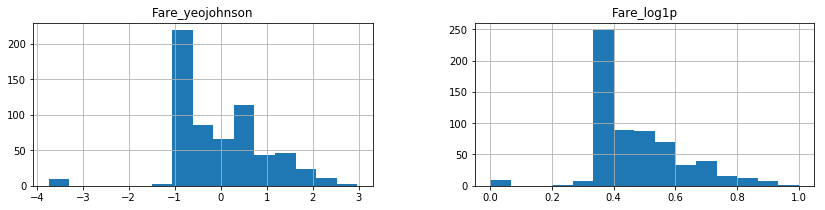

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14,3))
bins = 15

yeojohnson = PowerTransformer(method='yeo-johnson')
pd.DataFrame({'Fare_yeojohnson': yeojohnson.fit_transform(X_train.Fare.values.reshape(-1,1)).reshape(-1)}).hist(ax = axes[0], bins=bins)

def FareTransformer(feature_range):
    return Pipeline([('log1p', make_pipeline(Row_Flipper(), SimpleImputer(strategy='median'), FunctionTransformer(np.log1p, validate=False))),
                     ('scaler', MinMaxScaler(feature_range))
                    ])

pd.DataFrame(FareTransformer((0,1)).fit_transform(X_train.Fare)).rename(columns = {0: 'Fare_log1p'}).hist(ax = axes[1], bins=bins)

plt.show()

Notice that we retain the possibility of tuning *feature_range* of the *MinMaxScaler* above in a GridSearch later.

### Summary of the numerical features preprocessing
We choose to discretize and one-hot-encode three of the four numerical features using our *Discretizer*. The fourth, *Fare*, is the only feature that remains a continous variable, and we treat it with a logarithmic function. Two hyperparameters were defined along the way:

* the sequence of *Age*-tresholds used for discretization;
* feature_range that controls how the dense *Fare* dimension is glued together with the sparse 'ohe'-dimensions.

We combine those transformers into one using the scikit-learn's *ColumnTransformer* class.

In [29]:
def numerical_transformer(tresholds, feature_range):
    
    numerical_tr = []
    numerical_tr.append(('age_discretizer', Discretizer('age', tresholds), 'Age'))
    numerical_tr.append(('sibsp_discretizer', Discretizer('sibsp', tresholds = [0, 1], handle_missing=False), 'SibSp'))
    numerical_tr.append(('parch_discretizer', Discretizer('parch', tresholds = [0], handle_missing=False), 'Parch'))
    numerical_tr.append(('fare_transformer', FareTransformer(feature_range), 'Fare'))

    return ColumnTransformer(numerical_tr, sparse_threshold=0)

In [30]:
X_train[numerical_columns].shape

(623, 4)

In [31]:
numerical_transformer([5, 10, 20, 30, 50], (0,1)).fit_transform(X_train).shape

(623, 13)

In [32]:
numerical_transformer([5, 10, 20, 30, 50], (0,1)).fit_transform(X_train)[:2]

array([[0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 0.63946275],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.35295528]])

---
---
## Examine the categorical features

In [33]:
categorical_columns

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass']

---
**Name**

Names are unique ...

In [34]:
(X_train.Name.value_counts().values == np.ones(len(X_train))).all()

True

... but thay can be accompanied by one of the customary titles, like *Miss*, *Mrs*, *Mr*, *Sir*, *Rev*, *Dr*, *Master*. We can use the occurances of those as featues.

In [35]:
titles = ["Mr.", "Mrs.", "Miss.", "Sir.", "Dr.", "Rev.", "Master"]
indeces_dict = {}

for title in titles:
    indeces_dict[title] = X_train.Name.str.find(title) >= 0
    
indeces_dict['other'] = reduce(lambda s1, s2: s1 & s2, indeces_dict.values())

Actually it seems that there are no names without any such title.

In [36]:
X_train.Name[indeces_dict['other']]

Series([], Name: Name, dtype: object)

Here are the counts in out train-set.

In [37]:
for title, indeces in indeces_dict.items():
    print(f"{title:>8}", indeces.sum() / len(X_train))

     Mr. 0.5842696629213483
    Mrs. 0.14606741573033707
   Miss. 0.1958266452648475
    Sir. 0.0016051364365971107
     Dr. 0.009630818619582664
    Rev. 0.008025682182985553
  Master 0.04173354735152488
   other 0.0


Here's our transformer. Let's treat *Master*s, *Reverand*s, *Doctor*s and *Sir*s as a single category. We will omit the *other* category.

In [38]:
class Title_Extractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.title_groups = [("Mr.",), ("Mrs.",), ("Miss.",), ("Sir.", "Dr.", "Rev.", "Master")]
        self.columns = []
        for title_group in self.title_groups:
            self.columns.append("_".join(title_group))
        return None
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        indeces_dict = {}
        zero = np.zeros(len(X)).astype('bool')
        for title_group, column in zip(self.title_groups, self.columns):
            indeces = []
            for title in title_group:
                indeces.append(X.str.find(title) >= 0)
            indeces_dict[column] = reduce(lambda s1, s2: s1 | s2, indeces, zero).astype('float')
        
        return pd.DataFrame(indeces_dict)

In [39]:
title_extractor = Title_Extractor()
title_extractor.transform(X_train.Name)[:4]

,Mr.,Mrs.,Miss.,Sir._Dr._Rev._Master
748,1.0,0.0,0.0,0.0
45,1.0,0.0,0.0,0.0
28,0.0,0.0,1.0,0.0
633,1.0,0.0,0.0,0.0


In [40]:
title_extractor.columns

['Mr.', 'Mrs.', 'Miss.', 'Sir._Dr._Rev._Master']

---
**Sex**:
* category is assumed to be binary
* and to have no missing values.
* We will simply map it to ones and zeros using the *OrdinalEncoder* class.

In [41]:
X_train.Sex.unique()

array(['male', 'female'], dtype=object)

In [42]:
X_train.Sex.value_counts(dropna=False)

male      406
female    217
Name: Sex, dtype: int64

In [43]:
sex_encoder = make_pipeline(Row_Flipper(), OrdinalEncoder())
sex_encoder.fit(X_train.Sex)

print({label: code for (label, code) in zip(X_train.Sex.unique(), sex_encoder.transform(X_train.Sex.unique()))})
sex_encoder.transform(X_train.Sex[:3])

{'male': array([1.]), 'female': array([0.])}


array([[1.],
       [1.],
       [0.]])

---
**Ticket**:

No missing values.

About 80% of *Ticket*s are unique.

Indyvidual values can bear some resemblance to each other in terms of their format, eg. *Ticket* 'PC 17483' seems more similar to 'PC 17757' than to 'C.A. 31921'. One could come up with countless more or less arbitrary categories to split this column into. Here's my proposition.

Attempt to extract a number from the *Ticket* string. Record:
* the first (leftmost) digit (or zero if no number was extracted), one-hot-encode;
* number of digits in the number (or zero if no number was extracted), one-hot-encode.


In [44]:
X_train.Ticket.isnull().sum()

0

In [45]:
len(X_train.Ticket.unique()) / len(X_train.Ticket)

0.8298555377207063

In [46]:
X_train.Ticket.unique()[:20]

array(['113773', 'S.C./A.4. 23567', '330959', '112052',
       'STON/O2. 3101279', '248727', '112277', '248731', 'PC 17609',
       '315090', '36866', '4137', '248733', '349212', '8475',
       'A/4. 39886', '16988', '3101265', '347060', '2908'], dtype=object)

In [47]:
def take_num_len(ticket):
    try:
        num_str = re.match('(\d+)$', ticket).group(1)
        return len(num_str)
    except:
        return 0


def take_first_digit(ticket):
    try:
        num_str = re.match('(\d+)$', ticket).group(1)
        return int(num_str[0])
    except:
        return 0

In [48]:
X_train.Ticket.apply(take_num_len).value_counts()

6    277
0    170
5     90
4     70
7     14
3      2
Name: Ticket, dtype: int64

In [49]:
X_train.Ticket.apply(take_first_digit).value_counts()

3    206
0    170
2    132
1     95
4      9
6      5
7      3
8      2
5      1
Name: Ticket, dtype: int64

Most of the *Ticket*s either don't end with a number at all, or the number in them is between 4 and 6 digits long and starts with '1', '2' or '3'.

* Let's treat numbers (if found) which are longer than '6' or shorter than '5' as a single category.
* Let's treat numbers that start with a digit other than '1', '2' or '3' as a single category.

In [50]:
def take_num_len56(ticket):
    try:
        num_str = re.match('(\d+)$', ticket).group(1)
        return len(num_str) if len(num_str) in [5, 6] else -1
    except:
        return 0

def take_first_digit123(ticket):
    try:
        num_str = re.match('(\d+)$', ticket).group(1)
        return int(num_str[0]) if int(num_str[0]) in [1,2,3] else -1
    except:
        return 0

In [51]:
X_train.Ticket.apply(take_num_len56).value_counts()

 6    277
 0    170
 5     90
-1     86
Name: Ticket, dtype: int64

In [52]:
X_train.Ticket.apply(take_first_digit123).value_counts()

 3    206
 0    170
 2    132
 1     95
-1     20
Name: Ticket, dtype: int64

In [53]:
ticket_transformer_1 = make_pipeline(FunctionTransformer(np.vectorize(take_num_len56), validate=False), Row_Flipper(), OneHotEncoder(categories='auto'))
ticket_transformer_2 = make_pipeline(FunctionTransformer(np.vectorize(take_first_digit123), validate=False), Row_Flipper(), OneHotEncoder(categories='auto'))

In [54]:
ticket_transformer_1.fit_transform(X_train.Ticket).todense()[:3]

matrix([[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])

In [55]:
ticket_transformer_2.fit_transform(X_train.Ticket).todense()[:3]

matrix([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.]])

---
**Cabin**:

* 78% of *Cabin* labels are missing.
* There are about 150 unique *Cabin* values
* Majority of the entries is of the format similar to 'G6', 'F33', 'E101' etc.
* There are few cabins labeled without numbers, like 'T' and 'D.
* Some entries are a series of space-separated values, e.g. 'B96 B98'

In [56]:
X_train.Cabin.isnull().sum() / len(X_train.Cabin)

0.7817014446227929

In [57]:
len(X_train.Cabin.unique())

114

In [58]:
X_train.Cabin.value_counts()[:6]

F33        3
G6         3
E44        2
D          2
E101       2
B58 B60    2
Name: Cabin, dtype: int64

Search for the 'uppercase-letter-possibly-followed-by-digits'-regex pattern. Most 'Cabins', if known, start with letters 'A' to 'E'.

Let's make the following categories:
* missing value
* A*
* ...
* E*
* other, including F*, G*, ..., and combinations of more letters

In [59]:
def quasilist_to_set(quasilist):
    try:
        return frozenset(quasilist)
    except:
        return quasilist

def extract_letter(X):
    PATTERN = '([A-Z])\d*'
    result = X.str.findall(PATTERN)
    result[result.isnull()] = np.nan
    return result.apply(quasilist_to_set)

letter_extractor = FunctionTransformer(extract_letter, validate=False)

letters = 'ABCDE'
letter_to_num = {frozenset(letter): number for (letter, number) in zip(letters, range(1,len(letters)+1))}
print('Letters explicitly looked for in the Ticket:', {set(set_).pop(): num for (set_, num) in letter_to_num.items()})
letter_to_num[np.nan] = 0
print("Assign '0' if no letter was extracted.")

def letter_categories(quasilist):
    return letter_to_num[quasilist] if quasilist in letter_to_num else -1

print("Assign '-1' if some other letter(s) were extracted.")

letter_encoder = FunctionTransformer(np.vectorize(letter_categories), validate=False)

print("Value counts found in the 'X_train':")

pd.Series(make_pipeline(letter_extractor, letter_encoder).transform(X_train.Cabin)).value_counts()

Letters explicitly looked for in the Ticket: {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
Assign '0' if no letter was extracted.
Assign '-1' if some other letter(s) were extracted.
Value counts found in the 'X_train':


 0    487
 3     35
 2     29
 5     24
 4     23
 1     13
-1     12
dtype: int64

In [60]:
cabin_transformer = make_pipeline(letter_extractor, letter_encoder, Row_Flipper(), OneHotEncoder(categories='auto'))
cabin_transformer.fit_transform(X_train.Cabin).todense()[:3]

matrix([[0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]])

---
**Embarked**:
* There are three categories with a well-defined meaning.
* Some missing values may happen, but relatively few.

In [61]:
X_train.Embarked.value_counts(dropna=False)

S      444
C      124
Q       53
NaN      2
Name: Embarked, dtype: int64

Impute the most-frequent value in place of the missing values, and one-hot-encode.

In [62]:
embarked_transformer = make_pipeline(Row_Flipper(), SimpleImputer(strategy='most_frequent'), OneHotEncoder(categories='auto'))
embarked_transformer.fit_transform(X_train.Embarked)[:3].todense()

matrix([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]])

---
**Pclass**:

* one-hot-encode the three numbers interpreted as unstructered categories

In [63]:
X_train.Pclass.value_counts(dropna=False)

3    346
1    147
2    130
Name: Pclass, dtype: int64

In [64]:
pclass_transformer = make_pipeline(Row_Flipper(), OneHotEncoder(categories='auto'))
pclass_transformer.fit_transform(X_train.Pclass)[:3].todense()

matrix([[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.]])

### Summary of the categorical features preprocessing

* Name: extract the title, ohe
* Sex: 1: male, 0: female
* Ticket: two set of features based on the number extracted from a record: a) number of digits, b) first digit; missing values and lack-of-the-number treated as additional categories.
* Cabin: seven categories (including missing value), based on the letter in a record, ohe
* Embarked: ohe, impute nans with most-frequent label
* Pclass: ohe, no nan handling

In [65]:
categorical_tr = []
categorical_tr.append(('title_extractor', Title_Extractor(), 'Name'))
categorical_tr.append(('sex_encoder', sex_encoder, 'Sex'))
categorical_tr.append(('ticket_transformer_1', ticket_transformer_1, 'Ticket'))
categorical_tr.append(('ticket_transformer_2', ticket_transformer_2, 'Ticket'))
categorical_tr.append(('cabin_transformer', cabin_transformer, 'Cabin'))
categorical_tr.append(('embarked_transformer', embarked_transformer, 'Embarked'))
categorical_tr.append(('pclass_transformer', pclass_transformer, 'Pclass'))

categorical_transformer = ColumnTransformer(categorical_tr)

In [66]:
X_train[categorical_columns].shape

(623, 6)

In [67]:
categorical_transformer.fit_transform(X_train).shape

(623, 27)

---
---
## Transform and combine the numerical and categorical features

In [68]:
def preprocess_pipe(age_tresholds=[2,5], fare_range=(0,1)):
    transformers = [
        ('numerical_transformer', numerical_transformer(age_tresholds, fare_range)),
        ('categorical_transformer', categorical_transformer)
    ]
    return FeatureUnion(transformers)

In [69]:
preprocess = preprocess_pipe()

In [70]:
X_train_preprocessed = preprocess.fit_transform(X_train)
X_train_preprocessed.shape

(623, 37)

---
## Reproduce/compe-up-with some column names for the features

In [71]:
age_columns = preprocess.transformer_list[0][1].transformers[0][1].columns
age_columns

['age_(-inf,2]', 'age_(2,5]', 'age_(5,inf]', 'age_missing']

In [72]:
sibsp_columns = preprocess.transformer_list[0][1].transformers[1][1].columns
sibsp_columns

['sibsp_(-inf,0]', 'sibsp_(0,1]', 'sibsp_(1,inf]']

In [73]:
parch_columns = preprocess.transformer_list[0][1].transformers[2][1].columns
parch_columns

['parch_(-inf,0]', 'parch_(0,inf]']

In [74]:
fare_columns = [f"fare_{preprocess.transformer_list[0][1].transformers[3][1].named_steps['scaler'].feature_range}"]
fare_columns

['fare_(0, 1)']

In [75]:
name_columns = ["name_" + title for title in preprocess.transformer_list[1][1].transformers[0][1].columns]
name_columns

['name_Mr.', 'name_Mrs.', 'name_Miss.', 'name_Sir._Dr._Rev._Master']

In [76]:
print(dict(enumerate(preprocess.transformer_list[1][1].transformers[1][1].named_steps['ordinalencoder'].categories_[0])))
sex_columns = ["sex"]
sex_columns

{0: 'female', 1: 'male'}


['sex']

In [77]:
ticket_1_columns = ["ticket_1_" + str(num) for num in preprocess.transformer_list[1][1].transformers[2][1].named_steps['onehotencoder'].categories_[0]]
ticket_1_columns

['ticket_1_-1', 'ticket_1_0', 'ticket_1_5', 'ticket_1_6']

In [78]:
ticket_2_columns = ["ticket_2_" + str(num) for num in preprocess.transformer_list[1][1].transformers[3][1].named_steps['onehotencoder'].categories_[0]]
ticket_2_columns

['ticket_2_-1', 'ticket_2_0', 'ticket_2_1', 'ticket_2_2', 'ticket_2_3']

In [79]:
cabin_columns = ["cabin_" + str(num) for num in preprocess.transformer_list[1][1].transformers[4][1].named_steps['onehotencoder'].categories_[0]]
cabin_columns

['cabin_-1', 'cabin_0', 'cabin_1', 'cabin_2', 'cabin_3', 'cabin_4', 'cabin_5']

In [80]:
embarked_columns = ["embarked_" + str(num) for num in preprocess.transformer_list[1][1].transformers[5][1].named_steps['onehotencoder'].categories_[0]]
embarked_columns                  

['embarked_C', 'embarked_Q', 'embarked_S']

In [81]:
pclass_columns = ["pclass_" + str(num) for num in preprocess.transformer_list[1][1].transformers[6][1].named_steps['onehotencoder'].categories_[0]]
pclass_columns

['pclass_1', 'pclass_2', 'pclass_3']

In [82]:
columns = np.concatenate([age_columns, sibsp_columns, parch_columns, fare_columns, name_columns, sex_columns, ticket_1_columns, ticket_2_columns, cabin_columns, embarked_columns, pclass_columns])
columns.shape

(37,)

---
## Examine importance of the features
using univariate statistical tests implemented in sklearn

#### $\chi^2$ - test

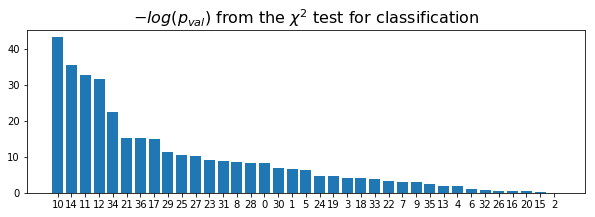

In [83]:
feature_selector_chi2 = SelectKBest(chi2, k='all')
feature_selector_chi2.fit(X_train_preprocessed, y_train)

pvalues_chi2 = feature_selector_chi2.pvalues_
ranking_chi2 = sorted(range(len(pvalues_chi2)), key=lambda feature: pvalues_chi2[feature])
feature_ranks_chi2 = dict(zip(ranking_chi2, range(len(ranking_chi2))))

plt.figure(figsize=(10,3))
plt.bar(range(len(ranking_chi2)), -np.log(pvalues_chi2[ranking_chi2]), tick_label=ranking_chi2)
plt.title('$-log(p_{val})$ from the $\chi^2$ test for classification', fontsize=16)
plt.show()

#### F-value - test

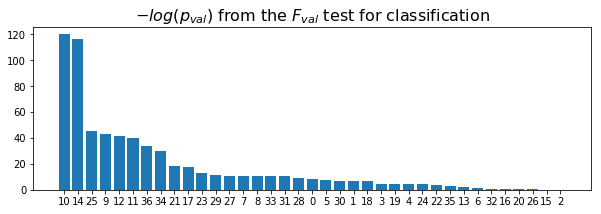

In [84]:
feature_selector_fscore = SelectKBest(f_classif, k='all')
feature_selector_fscore.fit(X_train_preprocessed, y_train)

pvalues_fscore = feature_selector_fscore.pvalues_
ranking_fscore = sorted(range(len(pvalues_fscore)), key=lambda feature: pvalues_fscore[feature])
feature_ranks_fscore = dict(zip(ranking_fscore, range(len(ranking_fscore))))

plt.figure(figsize=(10,3))
plt.bar(range(len(ranking_fscore)), -np.log(pvalues_fscore[ranking_fscore]), tick_label=ranking_fscore)
plt.title('$-log(p_{val})$ from the $F_{val}$ test for classification', fontsize=16)
plt.show()

#### Mutual information

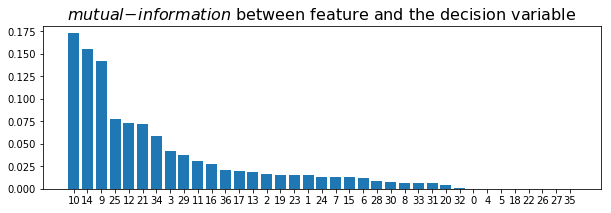

In [85]:
feature_selector_info = SelectKBest(mutual_info_classif, k='all')
feature_selector_info.fit(X_train_preprocessed, y_train)

info_scores = feature_selector_info.scores_
ranking_info = sorted(range(len(info_scores)), key=lambda feature: info_scores[feature], reverse=True)
feature_ranks_info = dict(zip(ranking_info, range(len(ranking_info))))

plt.figure(figsize=(10,3))
plt.bar(range(len(ranking_info)), info_scores[ranking_info], tick_label=ranking_info)
plt.title('$mutual\!-\!information$ between feature and the decision variable', fontsize=16)
plt.show()

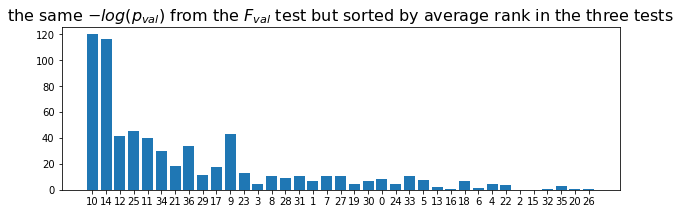

In [86]:
feature_ranks = [feature_ranks_chi2, feature_ranks_fscore, feature_ranks_info]
avg_feature_ranks = {column: None for column in range(len(columns))}

for column in range(len(columns)):
    avg_feature_ranks[column] = np.mean([rank[column] for rank in feature_ranks])
    
features_sorted = sorted(avg_feature_ranks, key = lambda feature: avg_feature_ranks[feature])

plt.figure(figsize=(10,3))
plt.bar(range(len(features_sorted)), -np.log(pvalues_fscore[features_sorted]), tick_label=features_sorted)
plt.title('the same $-log(p_{val})$ from the $F_{val}$ test but sorted by average rank in the three tests', fontsize=16)
plt.show()

In [87]:
pprint(list(zip(range(len(columns)), columns)))

[(0, 'age_(-inf,2]'),
 (1, 'age_(2,5]'),
 (2, 'age_(5,inf]'),
 (3, 'age_missing'),
 (4, 'sibsp_(-inf,0]'),
 (5, 'sibsp_(0,1]'),
 (6, 'sibsp_(1,inf]'),
 (7, 'parch_(-inf,0]'),
 (8, 'parch_(0,inf]'),
 (9, 'fare_(0, 1)'),
 (10, 'name_Mr.'),
 (11, 'name_Mrs.'),
 (12, 'name_Miss.'),
 (13, 'name_Sir._Dr._Rev._Master'),
 (14, 'sex'),
 (15, 'ticket_1_-1'),
 (16, 'ticket_1_0'),
 (17, 'ticket_1_5'),
 (18, 'ticket_1_6'),
 (19, 'ticket_2_-1'),
 (20, 'ticket_2_0'),
 (21, 'ticket_2_1'),
 (22, 'ticket_2_2'),
 (23, 'ticket_2_3'),
 (24, 'cabin_-1'),
 (25, 'cabin_0'),
 (26, 'cabin_1'),
 (27, 'cabin_2'),
 (28, 'cabin_3'),
 (29, 'cabin_4'),
 (30, 'cabin_5'),
 (31, 'embarked_C'),
 (32, 'embarked_Q'),
 (33, 'embarked_S'),
 (34, 'pclass_1'),
 (35, 'pclass_2'),
 (36, 'pclass_3')]


#### Feature-selection, conclusions:
* the three tests agree which are the few (about 8-16) least helpful features
* so lets throw those featues away using the *SelectKBest*
* bare in mind that this choice was made with a particular values of the *age_tresholds* and *fare_range* hyperparameters chosen above in the *preprocess* pipe

In [88]:
class DropKWorst(BaseEstimator, TransformerMixin):
    def __init__(self, k):
        self.k = k
        return None
    
    def fit(self, X, y):
        self.SelectKBest = SelectKBest(f_classif, k = X.shape[1] - self.k).fit(X, y)
        return self
        
    def transform(self, X):
        return self.SelectKBest.transform(X)

In [89]:
drop_dim = 12
print(f"Select {X_train_preprocessed.shape[1] - drop_dim} most useful features using the $\chi^2$ test")

feature_selector_info = DropKWorst(k=drop_dim).fit(X_train_preprocessed, y_train)

X_train_preprocessed_selected = feature_selector_info.transform(X_train_preprocessed)

Select 25 most useful features using the $\chi^2$ test


In [90]:
X_train_preprocessed_selected.shape

(623, 25)

---
## Examine the *explained variance* in PCA-directions
(without *whitening*, i.e. shifting and rescaling the data)

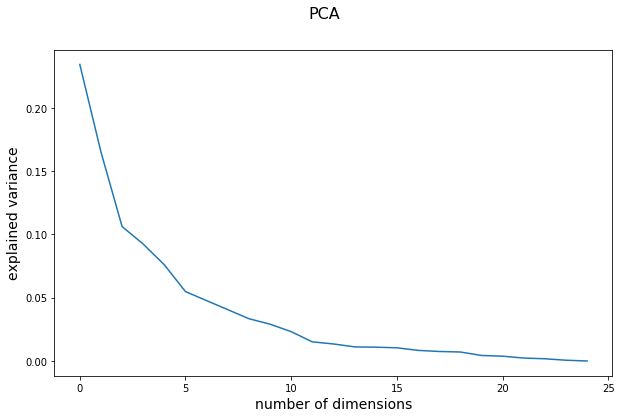

In [91]:
pca = PCA()
pca.fit(X_train_preprocessed_selected)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(pca.explained_variance_ratio_)
fig.suptitle('PCA', fontsize=16)
ax.set_xlabel('number of dimensions', fontsize=14)
ax.set_ylabel('explained variance', fontsize=14)
plt.show()

**Conclusion:**
One may significantly reduce the number of features using PCA. The one thing to bare in mind at this pont is that, doing this, we introduce negative values to the data.

Let's wrap the *PCA* class to retain the possibility of not using it at all.

In [92]:
class PCA_switch(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        return None
    
    def fit(self, X, y=None):
        if self.n_components > 0:
            self.PCA = PCA(self.n_components).fit(X)
        return self
        
    def transform(self, X):
        return self.PCA.transform(X) if self.n_components > 0 else X

In [93]:
(X_train_preprocessed_selected < 0).any()

False

In [94]:
X_train_preprocessed_selected_dimreduced = PCA_switch(n_components=-1).fit_transform(X_train_preprocessed_selected)

In [95]:
X_train_preprocessed_selected_dimreduced[X_train_preprocessed_selected_dimreduced < 0]

array([], dtype=float64)

---
---
## Write the process of building a preprocessing Pipeline to a standalone script.

In [96]:
%%writefile build_preprocess_pipe.py

import numpy as np
import pandas as pd
import re
from functools import reduce
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

def row_to_column(row):
    if type(row) == type(pd.Series()):
        return pd.DataFrame(row)
    elif type(row) == type(np.empty(0)):
        return row.reshape(-1,1)
    else:
        raise ValueError("row_to_column expected pandas Series or 1D numpy array")
        
class Row_Flipper(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def row_to_column(row):
        if type(row) == type(pd.Series()):
            return pd.DataFrame(row)
        elif type(row) == type(np.empty(0)):
            return row.reshape(-1,1)
        else:
            raise ValueError("row_to_column expected pandas Series or a numpy array")
        
    def transform(self, X):
        if len(X.shape) != 1:
            raise ValueError('RowFlipper expected 1D object, but got argument of shape {X.shape}')
        return row_to_column(X)


class Discretizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, name, tresholds, handle_missing=True):
        self.name = name
        self.tresholds = tresholds
        self.handle_missing = handle_missing
        self.columns = []
        self.inf_tresholds = [-np.inf] + tresholds + [np.inf]
        
        for index in range(len(self.inf_tresholds) - 1):
            self.columns.append(f"{self.name}_({self.inf_tresholds[index]},{self.inf_tresholds[index+1]}]")
        if self.handle_missing:
            self.columns.append(f"{self.name}_missing")
        return None
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        one_hots = np.zeros( (len(self.inf_tresholds) - 1 + int(self.handle_missing), len(X)) )
        for index in range(len(self.inf_tresholds) - 1):
            one_hots[index] = (X > self.inf_tresholds[index]) & (X <= self.inf_tresholds[index + 1])
            
        if self.handle_missing:
            one_hots[len(self.inf_tresholds) - 1] = X.isnull()
        elif X.isnull().any():
            raise ValueError("There's NAN's in the input")

        result = pd.DataFrame(one_hots.T, columns=self.columns, index = X.index)   
        return result

    

def FareTransformer(feature_range):
    return Pipeline([('log1p', make_pipeline(Row_Flipper(), SimpleImputer(strategy='median'), FunctionTransformer(np.log1p, validate=False))),
                     ('scaler', MinMaxScaler(feature_range))
                    ])

def numerical_transformer(tresholds, feature_range):
    
    numerical_tr = []
    numerical_tr.append(('age_discretizer', Discretizer('age', tresholds), 'Age'))
    numerical_tr.append(('sibsp_discretizer', Discretizer('sibsp', tresholds = [0, 1], handle_missing=False), 'SibSp'))
    numerical_tr.append(('parch_discretizer', Discretizer('parch', tresholds = [0], handle_missing=False), 'Parch'))
    numerical_tr.append(('fare_transformer', FareTransformer(feature_range), 'Fare'))

    return ColumnTransformer(numerical_tr, sparse_threshold=0)


class Title_Extractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.title_groups = [("Mr.",), ("Mrs.",), ("Miss.",), ("Sir.", "Dr.", "Rev.", "Master")]
        self.columns = []
        for title_group in self.title_groups:
            self.columns.append("_".join(title_group))
        return None
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        indeces_dict = {}
        zero = np.zeros(len(X)).astype('bool')
        for title_group, column in zip(self.title_groups, self.columns):
            indeces = []
            for title in title_group:
                indeces.append(X.str.find(title) >= 0)
            indeces_dict[column] = reduce(lambda s1, s2: s1 | s2, indeces, zero).astype('float')
        
        return pd.DataFrame(indeces_dict)

    
sex_encoder = make_pipeline(Row_Flipper(), OrdinalEncoder())


def take_num_len56(ticket):
    try:
        num_str = re.match('(\d+)$', ticket).group(1)
        return len(num_str) if len(num_str) in [5, 6] else -1
    except:
        return 0

def take_first_digit123(ticket):
    try:
        num_str = re.match('(\d+)$', ticket).group(1)
        return int(num_str[0]) if int(num_str[0]) in [1,2,3] else -1
    except:
        return 0
    
ticket_transformer_1 = make_pipeline(FunctionTransformer(np.vectorize(take_num_len56), validate=False), Row_Flipper(), OneHotEncoder(categories='auto'))
ticket_transformer_2 = make_pipeline(FunctionTransformer(np.vectorize(take_first_digit123), validate=False), Row_Flipper(), OneHotEncoder(categories='auto'))


def quasilist_to_set(quasilist):
    try:
        return frozenset(quasilist)
    except:
        return quasilist

def extract_letter(X):
    PATTERN = '([A-Z])\d*'
    result = X.str.findall(PATTERN)
    result[result.isnull()] = np.nan
    return result.apply(quasilist_to_set)

letter_extractor = FunctionTransformer(extract_letter, validate=False)

letters = 'ABCDE'
letter_to_num = {frozenset(letter): number for (letter, number) in zip(letters, range(1,len(letters)+1))}
letter_to_num[np.nan] = 0

def letter_categories(quasilist):
    return letter_to_num[quasilist] if quasilist in letter_to_num else -1

letter_encoder = FunctionTransformer(np.vectorize(letter_categories), validate=False)

cabin_transformer = make_pipeline(letter_extractor, letter_encoder, Row_Flipper(), OneHotEncoder(categories='auto'))


embarked_transformer = make_pipeline(Row_Flipper(), SimpleImputer(strategy='most_frequent'), OneHotEncoder(categories='auto'))


pclass_transformer = make_pipeline(Row_Flipper(), OneHotEncoder(categories='auto', handle_unknown='ignore'))


categorical_tr = []
categorical_tr.append(('title_extractor', Title_Extractor(), 'Name'))
categorical_tr.append(('sex_encoder', sex_encoder, 'Sex'))
categorical_tr.append(('ticket_transformer_1', ticket_transformer_1, 'Ticket'))
categorical_tr.append(('ticket_transformer_2', ticket_transformer_2, 'Ticket'))
categorical_tr.append(('cabin_transformer', cabin_transformer, 'Cabin'))
categorical_tr.append(('embarked_transformer', embarked_transformer, 'Embarked'))
categorical_tr.append(('pclass_transformer', pclass_transformer, 'Pclass'))
categorical_transformer = ColumnTransformer(categorical_tr, sparse_threshold=0)


def transform_pipe(age_tresholds=[5, 10, 20, 30, 50], fare_range=(0,1)):
    transformers = [
        ('numerical_transformer', numerical_transformer(age_tresholds, fare_range)),
        ('categorical_transformer', categorical_transformer)
    ]
    return FeatureUnion(transformers)


class DropKWorst(BaseEstimator, TransformerMixin):
    def __init__(self, k_features):
        self.k_features = k_features
        return None
    
    def fit(self, X, y):
        self.SelectKBest = SelectKBest(f_classif, k = X.shape[1] - self.k_features).fit(X, y)
        return self
        
    def transform(self, X):
        return self.SelectKBest.transform(X)
    

class PCA_switch(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
        return None
    
    def fit(self, X, y=None):
        if self.n_components > 0:
            self.PCA = PCA(self.n_components).fit(X)
        return self
        
    def transform(self, X):
        return self.PCA.transform(X) if self.n_components > 0 else X
    

def preprocess_pipe(age_tresholds=[2, 5], fare_range=(0,1), k_features=0, n_components=-1):
    return Pipeline([('transform', transform_pipe(age_tresholds, fare_range)),
                     ('feature_select', DropKWorst(k_features=0)),
                     ('pca', PCA_switch(n_components=-1))
                    ])

Overwriting build_preprocess_pipe.py


---
In the next notebook we will use the preprocessing pipeline developed here, and fit the preprocessed data to various classifiers.

Now, as a bonus:

## Make scatter-plots of dimensionally-reduced version of the data.

## For starters plot one of the featues, e.g. *Age*, against $log(1+{Fare})$.

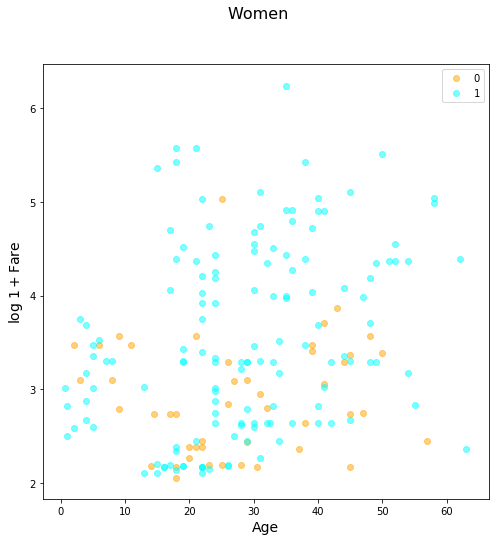

In [97]:
feature = 'Age'

X_train_fem_0 = X_train[(X_train.Sex=='female') & (y_train.values==0)]
X_train_fem_1 = X_train[(X_train.Sex=='female') & (y_train.values==1)]

fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(X_train_fem_0[feature], np.log1p(X_train_fem_0.Fare), c='orange', alpha=0.5, label="0")
plt.scatter(X_train_fem_1[feature], np.log1p(X_train_fem_1.Fare), c='cyan', alpha=0.5, label="1")
plt.legend()
fig.suptitle('Women', fontsize=16)
ax.set_xlabel(f'{feature}', fontsize=14)
ax.set_ylabel('$\log\;1+$Fare', fontsize=14)
plt.show()

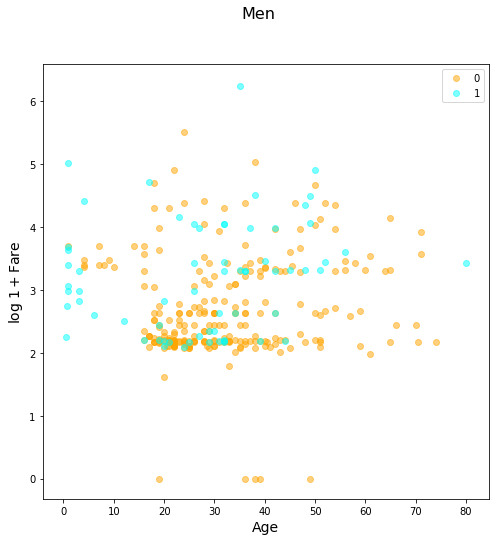

In [98]:
feature = 'Age'

X_train_male_0 = X_train[(X_train.Sex=='male') & (y_train.values==0)]
X_train_male_1 = X_train[(X_train.Sex=='male') & (y_train.values==1)]

fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(X_train_male_0[feature], np.log1p(X_train_male_0.Fare), c='orange', alpha=0.5, label="0")
plt.scatter(X_train_male_1[feature], np.log1p(X_train_male_1.Fare), c='cyan', alpha=0.5, label="1")
plt.legend()
fig.suptitle('Men', fontsize=16)
ax.set_xlabel(f'{feature}', fontsize=14)
ax.set_ylabel('$\log\;1+$Fare', fontsize=14)
plt.show()

## Now plot the features after preprocesing

### 2-dim PCA

In [99]:
X_train_pca = PCA(2).fit_transform(X_train_preprocessed_selected)
X_train_pca.shape

(623, 2)

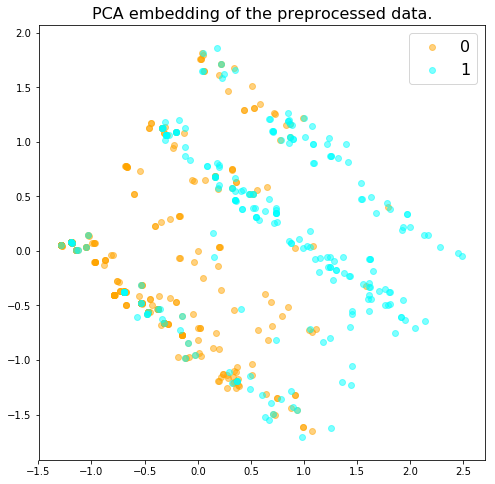

In [100]:
xa, ya = X_train_pca.reshape(-1, 2).T.tolist()

xa_0 = np.array(xa)[y_train.values==0]
ya_0 = np.array(ya)[y_train.values==0]
xa_1 = np.array(xa)[y_train.values==1]
ya_1 = np.array(ya)[y_train.values==1]

plt.figure(figsize=(8, 8))
plt.scatter(xa_0, ya_0, c='orange', alpha=0.5, label='0')
plt.scatter(xa_1, ya_1, c='cyan', alpha=0.5, label='1')
plt.title('PCA embedding of the preprocessed data.', {'fontsize': 16})
plt.legend(fontsize = 16)
plt.show()

### 2-dim *t-SNE*

In [101]:
X_train_tsne = TSNE(random_state=123).fit_transform(X_train_preprocessed_selected)
X_train_tsne.shape

(623, 2)

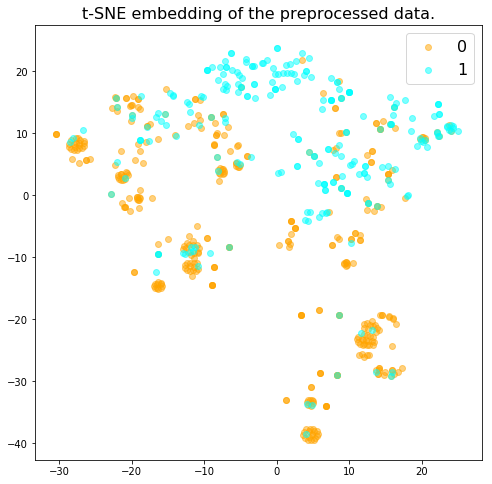

In [102]:
xb, yb = X_train_tsne.reshape(-1, 2).T.tolist()

xb_0 = np.array(xb)[y_train.values==0]
yb_0 = np.array(yb)[y_train.values==0]
xb_1 = np.array(xb)[y_train.values==1]
yb_1 = np.array(yb)[y_train.values==1]

plt.figure(figsize=(8, 8))
plt.scatter(xb_0, yb_0, c='orange', alpha=0.5, label='0')
plt.scatter(xb_1, yb_1, c='cyan', alpha=0.5, label='1')
plt.title('t-SNE embedding of the preprocessed data.', {'fontsize': 16})
plt.legend(fontsize = 16)
plt.show()

Some separation is already visible but the classification will not be trivial.

---
### End